# Custom kernel implementation

In [23]:
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.datasets import load_iris
from sklearn import svm
import matplotlib.pyplot as plt

In [39]:
# load toy dataset, 2 classes (50 samples each), 2 features
data = load_iris()
X = data.data
Y = data.target
X = data.data[Y != 0, :2]
Y = data.target[Y != 0]


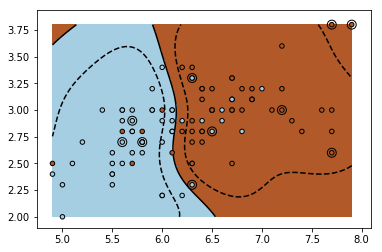

In [49]:
# Basic SVM example
n_sample = len(X)
order = np.random.permutation(n_sample)
X = X[order]
Y = Y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
Y_train = Y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
Y_test = Y[int(.9 * n_sample):]

clf = svm.SVC(kernel="rbf", gamma=4); # linear, rbf, poly
clf.fit(X_train, Y_train);

# plot
plt.figure()
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10, edgecolor='k')

x_min = X[:, 0].min()
x_max = X[:, 0].max()
y_min = X[:, 1].min()
y_max = X[:, 1].max()

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

plt.show()


## 

In [6]:
def rbf_kernel(X, sigma):
    K = np.zeros([X.shape[0], X.shape[0]])

    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = np.exp(-cdist(X[i, :].reshape(1, -1), X[j, :].reshape(1, -1), 'sqeuclidean') / (sigma ** 2))

    return K

In [7]:

print(X)
print(Y)
sigma = 0.2
K = rbf_kernel(X, sigma)
print(K)

#D = np.sum(K, axis=1)
#D_inv = np.linalg.inv(np.diagonal(D))

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]
 [5.4 3.7]
 [4.8 3.4]
 [4.8 3. ]
 [4.3 3. ]
 [5.8 4. ]
 [5.7 4.4]
 [5.4 3.9]
 [5.1 3.5]
 [5.7 3.8]
 [5.1 3.8]
 [5.4 3.4]
 [5.1 3.7]
 [4.6 3.6]
 [5.1 3.3]
 [4.8 3.4]
 [5.  3. ]
 [5.  3.4]
 [5.2 3.5]
 [5.2 3.4]
 [4.7 3.2]
 [4.8 3.1]
 [5.4 3.4]
 [5.2 4.1]
 [5.5 4.2]
 [4.9 3.1]
 [5.  3.2]
 [5.5 3.5]
 [4.9 3.6]
 [4.4 3. ]
 [5.1 3.4]
 [5.  3.5]
 [4.5 2.3]
 [4.4 3.2]
 [5.  3.5]
 [5.1 3.8]
 [4.8 3. ]
 [5.1 3.8]
 [4.6 3.2]
 [5.3 3.7]
 [5.  3.3]
 [7.  3.2]
 [6.4 3.2]
 [6.9 3.1]
 [5.5 2.3]
 [6.5 2.8]
 [5.7 2.8]
 [6.3 3.3]
 [4.9 2.4]
 [6.6 2.9]
 [5.2 2.7]
 [5.  2. ]
 [5.9 3. ]
 [6.  2.2]
 [6.1 2.9]
 [5.6 2.9]
 [6.7 3.1]
 [5.6 3. ]
 [5.8 2.7]
 [6.2 2.2]
 [5.6 2.5]
 [5.9 3.2]
 [6.1 2.8]
 [6.3 2.5]
 [6.1 2.8]
 [6.4 2.9]
 [6.6 3. ]
 [6.8 2.8]
 [6.7 3. ]
 [6.  2.9]
 [5.7 2.6]
 [5.5 2.4]
 [5.5 2.4]
 [5.8 2.7]
 [6.  2.7]
 [5.4 3. ]
 [6.  3.4]
 [6.7 3.1]
 [6.3 2.3]
 [5.6 3. ]
 [5.5 2.5]
 [5.5 2.6]